In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import tensorflow as tf

In [3]:
from Data_loader import *
from Neural_network import *

In [4]:
x = tf.placeholder('float', [None, 4096])
#y = tf.placeholder('float')
hl = tf.placeholder('float') #hinge_loss

In [5]:
Anomaly,Normal=get_training_set("./out")

In [6]:
output , weights_1 , weights_2, weights_3 = dnn_network(x)
cost = 0.001 * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3)) + hl
optimizer = tf.train.AdagradOptimizer(0.001).minimize(cost)


In [7]:
saver = tf.train.Saver()  # to save model

In [8]:
# Stoering details for tensorboard
tf.summary.scalar('cost', cost)
tf.summary.histogram('h_w1', weights_1)
tf.summary.histogram('h_w2',weights_2)
tf.summary.histogram('h_w3',weights_3)
merged_summary_op = tf.summary.merge_all()

In [9]:
# Initialize and run
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [25]:
epochs=501
print_epoch =20
save_model_epoch=500
count=0

In [26]:

#los =[] #loss array

train_writer = tf.summary.FileWriter("./logs/Dnn_session",tf.get_default_graph())

for epoch in range(epochs):

    i=0
    anomaly,normal = get_training_set("./out") # getting data

    while i < len(anomaly):

        start = i

        end =i+batch_size

        batch_x =np.array(anomaly[start:end])
        batch_y =np.array(normal[start:end])  # Single Video of normal and anomolus


        anomaly_score = sess.run(output,feed_dict={x: batch_x})
        normal_score,W1= sess.run([output,weights_1],feed_dict={x: batch_y})  # calaculated score of anomolus and normal video

        # calculation of hinge loss-------------------------------------------------
        anomaly_score = anomaly_score.flatten()
        normal_score = normal_score.flatten()

        l = max(0.0,(1-anomaly_score.max()+normal_score.max())) #loss implementation

        add = 0.0
        for index in range(len(anomaly_score) - 1):
            add += (anomaly_score[index] - anomaly_score[index+1]) ** 2

        final_cost = l + (add*1.0 + anomaly_score.sum()) * 0.00008 

        # loss completd----------------------------------------------------------

        o,_,cst,summ = sess.run([optimizer,output,cost,merged_summary_op], feed_dict={hl : final_cost,x: batch_x})


        i =i + batch_size

        train_writer.add_summary(summ,count) # summaries for tensorBoard

        count += 1
    #los.append(cst)

    if epoch %print_epoch ==1:
        print('Epoch', epoch, 'completed out of',epochs,'loss:',cst)

    if epoch%save_model_epoch == 1:
        saved_path = saver.save(sess, './model_logs/'+str(epoch)+'/model', global_step=epoch)


Epoch 1 completed out of 2 loss: 293.29483


In [15]:
import matplotlib.pyplot as plt

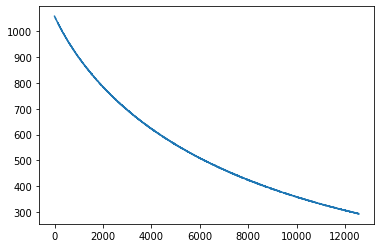

In [21]:
plt.plot(los)